### Loading liberary and dataset


In [1]:
library(ISLR)
library(glmnet)
library(ggplot2)


Loading required package: Matrix

Loaded glmnet 4.1-2



In [2]:
names(Hitters)

dim(Hitters)
sum(is.na(Hitters$Salary))
Hitters <- na.omit(Hitters)

dim(Hitters)
sum(is.na(Hitters))


[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

[1] 322  20

[1] 59

[1] 263  20

[1] 0

### Fitting using Ridge


In [3]:
# Create dataset for fitting
# Why remove the 1st column? Because that is the intercept which is all 1.
x <- model.matrix(Salary ~ ., Hitters)[, -1] # x: 19 predictors
y <- Hitters$Salary

# Consider a vector of lambda values ranging from 10^10 to 10^-2
grid <- 10^seq(10, -4, length = 100) # length: number of points of grid1

# alpha=0:Ridge alpha=1: LASSO
ridge.mod <- glmnet(x, y, alpha = 0, lambda = grid)

dim(coef(ridge.mod)) # 20*100


[1]  20 100

#### Results


In [4]:
# The 50th value of lambda
ridge.mod$lambda[50]
print(coef(ridge.mod)[, 50])

# Norm of the estimates
sqrt(sum(coef(ridge.mod)[-1, 50]^2))


[1] 1176.812

  (Intercept)         AtBat          Hits         HmRun          Runs 
103.264908545   0.112176616   0.541939406   1.319487303   0.822507326 
          RBI         Walks         Years        CAtBat         CHits 
  0.778759685   1.112649626   2.819387010   0.009910226   0.040274771 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.294545171   0.080662190   0.083800360   0.071785837   8.828013334 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-39.889415666   0.089579158   0.011748831  -0.407016066   6.519575724 


[1] 41.52592

In [5]:
# The 60th value of lambda
ridge.mod$lambda[60]
print(coef(ridge.mod)[, 60])

# Norm of the estimates
sqrt(sum(coef(ridge.mod)[-1, 60]^2))


[1] 45.34879

  (Intercept)         AtBat          Hits         HmRun          Runs 
 5.265842e+01 -3.937534e-01  2.055736e+00 -1.326110e+00  1.138115e+00 
          RBI         Walks         Years        CAtBat         CHits 
 7.961802e-01  2.790546e+00 -6.624475e+00  4.743321e-03  1.096095e-01 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 6.328967e-01  2.299769e-01  2.249533e-01 -1.649857e-01  4.703367e+01 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-1.191161e+02  2.525797e-01  1.275736e-01 -3.349992e+00 -1.071747e+01 


[1] 128.7916

In [6]:
# For new value of lambda
# For example, lambda=25
print(predict(ridge.mod, s = 25, type = "coefficients")[1:20, ])


  (Intercept)         AtBat          Hits         HmRun          Runs 
 8.245119e+01 -6.959955e-01  2.818123e+00 -1.345421e+00  9.903751e-01 
          RBI         Walks         Years        CAtBat         CHits 
 7.030201e-01  3.405989e+00 -9.094518e+00 -2.630076e-03  1.358856e-01 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 6.919975e-01  3.062202e-01  2.629339e-01 -2.842847e-01  5.340327e+01 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-1.228421e+02  2.642634e-01  1.721486e-01 -3.690443e+00 -1.830519e+01 


#### Cross Validation for Ridge


In [7]:
# Split the data into a training and a test set
set.seed(1)
train <- sample(1:nrow(x), nrow(x) / 2)
test <- (-train)
y.test <- y[test]

# Fit ridge regression on training data
grid <- 10^seq(10, -4, length = 100)
ridge.mod <- glmnet(x[train, ], y[train], alpha = 0, lambda = grid)

# Predict on test set using lamda=4, 1e10, 0
ridge.pred1 <- predict(ridge.mod, s = 4, newx = x[test, ])
mean((ridge.pred1 - y.test)^2) # test MSE

ridge.pred2 <- predict(ridge.mod, s = 1e10, newx = x[test, ])
mean((ridge.pred2 - y.test)^2)

ridge.pred3 <- predict(ridge.mod, s = 0, newx = x[test, ])
mean((ridge.pred3 - y.test)^2)


[1] 142234

[1] 224669.8

[1] 167004.4

#### Select Tuning Parameters


[1] 326.0828

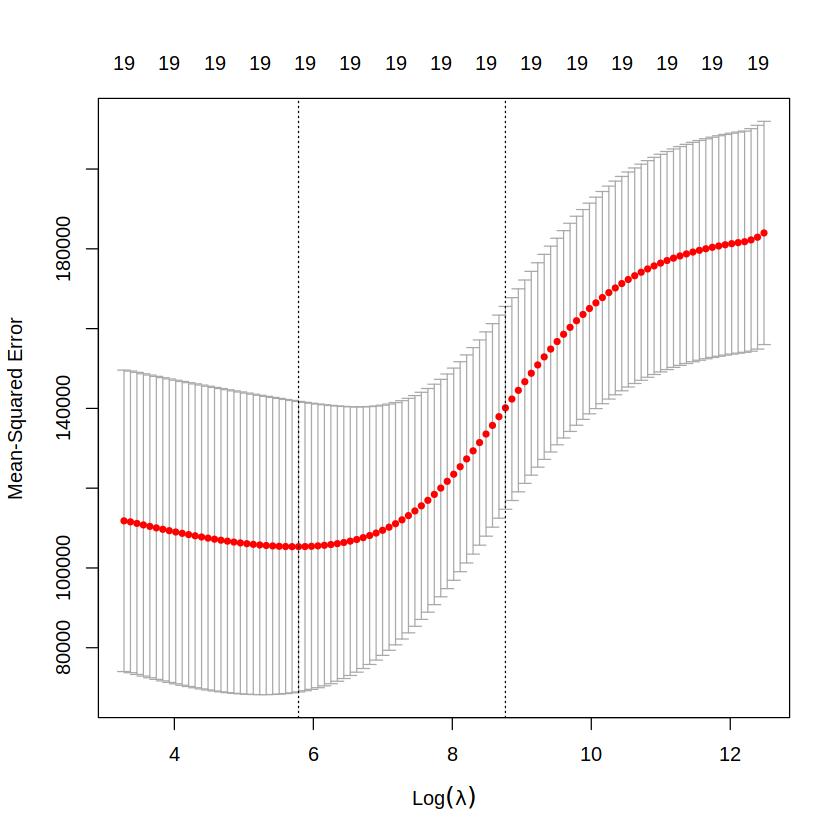

In [8]:
# Cross validation to get the best lambda
set.seed(1)
cv.out <- cv.glmnet(x[train, ], y[train], alpha = 0) # Default is 10-folds CV
plot(cv.out)

bestlam <- cv.out$lambda.min
bestlam


In [9]:
# Now predict with the best lambda
ridge.pred <- predict(ridge.mod, s = bestlam, newx = x[test, ])
mean((ridge.pred - y.test)^2)

# Refit ridge regression on the full dataset
out <- glmnet(x, y, alpha = 0)
print(predict(out, type = "coefficients", s = bestlam)[1:20, ])


[1] 139835.5

 (Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 15.44383135   0.07715547   0.85911581   0.60103107   1.06369007   0.87936105 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.62444616   1.35254780   0.01134999   0.05746654   0.40680157   0.11456224 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.12116504   0.05299202  22.09143189 -79.04032637   0.16619903   0.02941950 
      Errors   NewLeagueN 
 -1.36092945   9.12487767 


### Fitting using Lasso


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


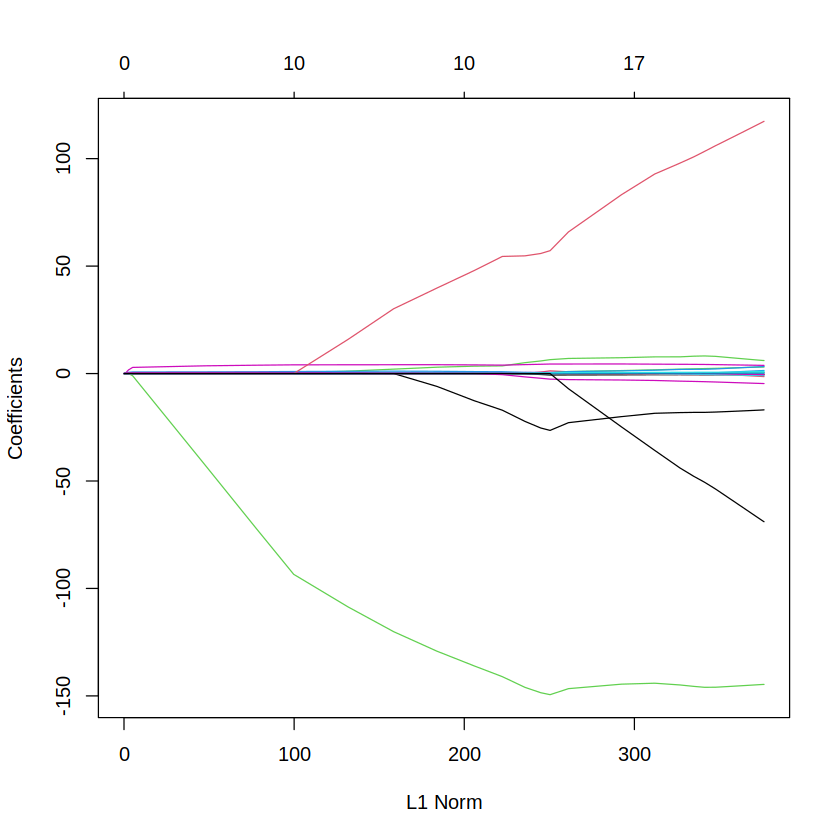

In [10]:
x <- model.matrix(Salary ~ ., Hitters)[, -1] # x: 19 predictors
y <- Hitters$Salary
grid <- 10^seq(10, -4, length = 100)

# For LASSO we use alpha=1 in glmnet
# Use penalty to give a multiplier before lambda
# penalty <- rep(1, ncol(x))

lasso.mod <- glmnet(x[train, ], y[train], alpha = 1, lambda = grid)
plot(lasso.mod)


[1] 9.286955

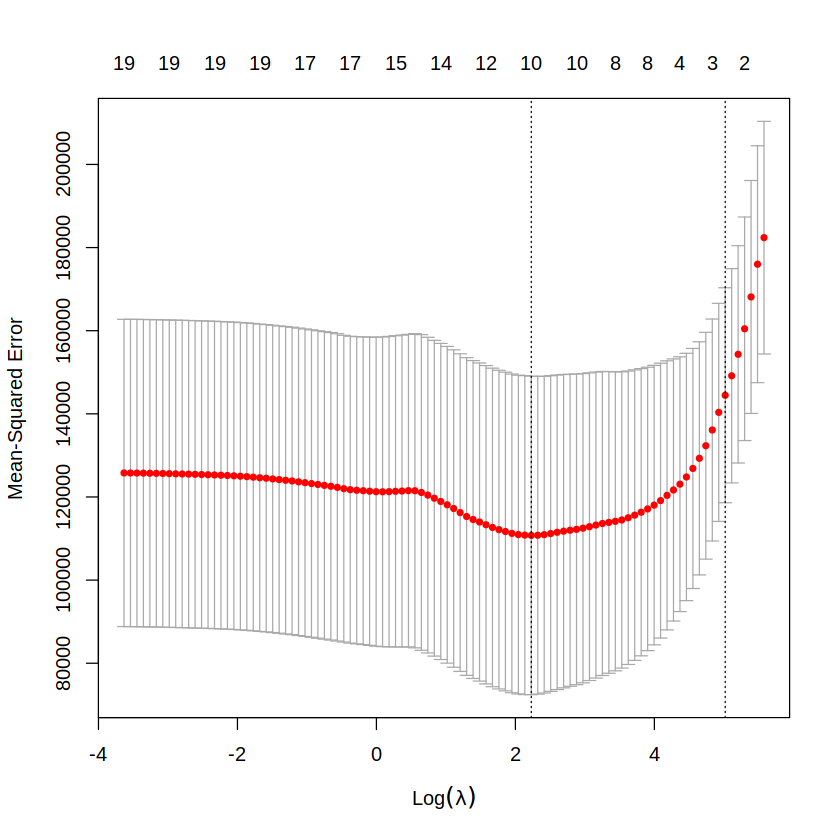

In [11]:
# Use CV to find the optimal lambda
set.seed(1)
cv.out <- cv.glmnet(x[train, ], y[train], alpha = 1)
# We can set the range of lamba, or cv.glmnet will find suitable range.
plot(cv.out)
bestlam <- cv.out$lambda.min
bestlam


In [12]:
# Use best lambda for prediction
lasso.pred <- predict(lasso.mod, s = bestlam, newx = x[test, ])
mean((lasso.pred - y.test)^2)
out <- glmnet(x, y, alpha = 1, lambda = grid)
lasso.coef <- predict(out, type = "coefficients", s = bestlam)[1:20, ]


[1] 143608

In [13]:
# Check the estimated coefficients and the '0' coefficients
print(lasso.coef)


  (Intercept)         AtBat          Hits         HmRun          Runs 
  -3.05642701    0.00000000    2.02578944    0.00000000    0.00000000 
          RBI         Walks         Years        CAtBat         CHits 
   0.00000000    2.26874774    0.00000000    0.00000000    0.00000000 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
   0.01684745    0.21140626    0.41970339    0.00000000   20.49202767 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-116.59448895    0.23715369    0.00000000   -0.94744108    0.00000000 


In [14]:
# Check the estimated coefficients without the '0' coefficients
print(lasso.coef[lasso.coef != 0])


  (Intercept)          Hits         Walks        CHmRun         CRuns 
  -3.05642701    2.02578944    2.26874774    0.01684745    0.21140626 
         CRBI       LeagueN     DivisionW       PutOuts        Errors 
   0.41970339   20.49202767 -116.59448895    0.23715369   -0.94744108 


### More on LASSO


For most of experiments, scaling is necessary.
We need to scale trainset of both x and y to 0 mean and 1 std.
Also, use the mean and std of train set to scale test set.

Before scaling, the magnitude of each predictor is different, which will cause the coefficient into different magnitude.
After scaling, the coefficients can be compared.


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


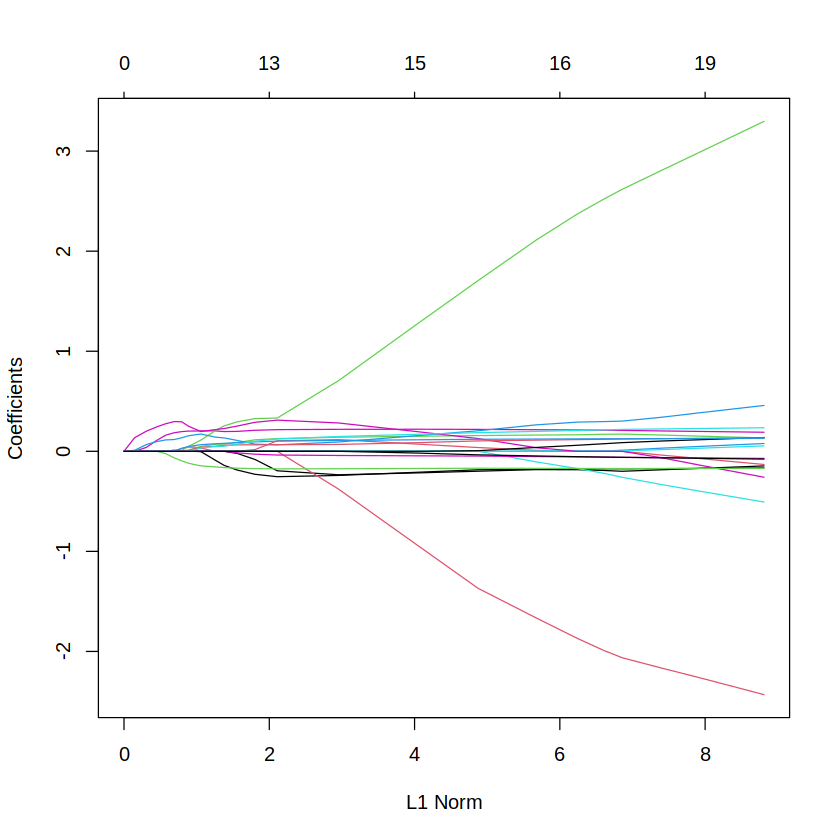

In [15]:
x_train <- x[train, ]
y_train <- y[train]

for (i in 1:ncol(x_train)) {
    mean_i <- mean(x_train[, i])
    std_i <- sd(x_train[, i])
    x_train[, i] <- (x_train[, i] - mean_i) / std_i
}
mean_y <- mean(y_train)
std_y <- sd(y_train)
y_train <- (y_train - mean_y) / std_y

lasso.mod <- glmnet(x_train, y_train, alpha = 1, lambda = grid)
plot(lasso.mod)


In [16]:
lasso_coef <- predict(lasso.mod, type = "coefficients")


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 84 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 84 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 83 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 83 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 79 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 79 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 90 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 88 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 88 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 74 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 74 row

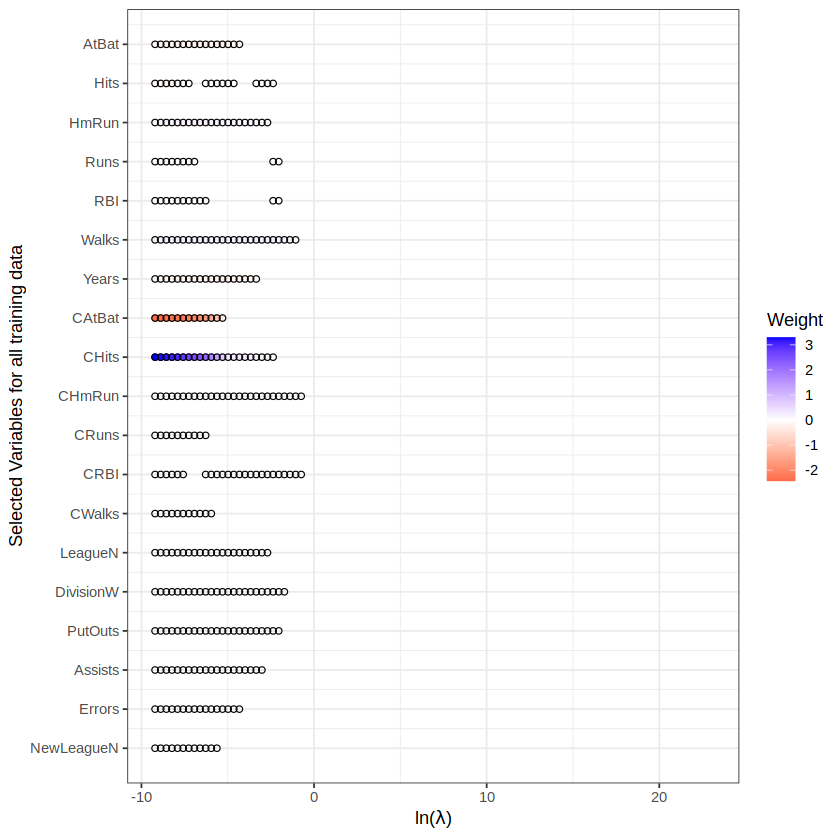

In [17]:
# Plot which variables are choosed for each lambda

number <- length(grid)
variables_all_weight <- t(as.matrix(lasso_coef))
variables_all_select <- array(0, dim = c(number, ncol(x) + 1))
for (h in (1:(ncol(x) + 1))) {
    variables_all_select[, h] <- (abs(variables_all_weight[, h]) > 0.00000001) * h
}
coef_df <- as.matrix(variables_all_select)
coef_df <- 22 - coef_df
coef_df[which(coef_df == 22)] <- NaN
coef_df <- as.data.frame(coef_df)
log_grid <- as.data.frame(log(grid))
df <- cbind(log_grid, coef_df)
variables_label <- variables_all_weight
g <- ggplot(df, aes(x = log(grid))) +
    geom_point(aes(y = V2, colour = variables_label[, 2])) +
    geom_point(aes(y = V2), shape = 1) +
    geom_point(aes(y = V3, colour = variables_label[, 3])) +
    geom_point(aes(y = V3), shape = 1) +
    geom_point(aes(y = V4, colour = variables_label[, 4])) +
    geom_point(aes(y = V4), shape = 1) +
    geom_point(aes(y = V5, colour = variables_label[, 5])) +
    geom_point(aes(y = V5), shape = 1) +
    geom_point(aes(y = V6, colour = variables_label[, 6])) +
    geom_point(aes(y = V6), shape = 1) +
    geom_point(aes(y = V7, colour = variables_label[, 7])) +
    geom_point(aes(y = V7), shape = 1) +
    geom_point(aes(y = V8, colour = variables_label[, 8])) +
    geom_point(aes(y = V8), shape = 1) +
    geom_point(aes(y = V9, colour = variables_label[, 9])) +
    geom_point(aes(y = V9), shape = 1) +
    geom_point(aes(y = V10, colour = variables_label[, 10])) +
    geom_point(aes(y = V10), shape = 1) +
    geom_point(aes(y = V11), shape = 1) +
    geom_point(aes(y = V12), shape = 1) +
    geom_point(aes(y = V13), shape = 1) +
    geom_point(aes(y = V14), shape = 1) +
    geom_point(aes(y = V15), shape = 1) +
    geom_point(aes(y = V16), shape = 1) +
    geom_point(aes(y = V17), shape = 1) +
    geom_point(aes(y = V18), shape = 1) +
    geom_point(aes(y = V19), shape = 1) +
    geom_point(aes(y = V20), shape = 1) +
    scale_colour_gradient2("Weight", high = "blue", low = "red", mid = "white", midpoint = 0, guide = "colourbar", space = "Lab")

g <- g + ylim(2, 20)
y_labels <- colnames(x)
g <- g + scale_y_continuous(labels = y_labels, breaks = c(seq(20, 2, -1)))
g <- g + ylab("Selected Variables for all training data")
g <- g + xlab(expression(paste("ln(", lambda, ")"))) + theme_bw()
plot(g)
